# Missing Value and Outliers Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

sns.set(style='darkgrid')
%matplotlib inline

In [ ]:
data = pd.read_csv('../input/weather-dataset-rattle-package/weatherAUS.csv')
df=data.sample(20000).copy()
df.head()

In [ ]:
df.shape

In [ ]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)
null_values(df)

In [ ]:
df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
df[['RainToday', 'RainTomorrow']].isnull().sum()

In [ ]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    display(str.sort_values(by='Nulls', ascending=False))

summary(df)

In [ ]:
df[['RainToday','RainTomorrow']] = df[['RainToday','RainTomorrow']].replace({'Yes':1, 'No':0})

### Multivariate Imputation 

In [ ]:
# # Iterative Imputer default=BayesianRidge()

# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# df_multi_imputation = df.copy()
# idf = df_multi_imputation.drop(['Date','Location'], axis=1)
# idf = pd.get_dummies(idf, drop_first=True, columns = ['WindDir9am','WindDir3pm','WindGustDir'])

# imp_mean = IterativeImputer(missing_values=np.nan, initial_strategy='mean', random_state=42)
# df_imputed_bayesian = pd.DataFrame(imp_mean.fit_transform(idf), index=idf.index, columns=idf.columns)
# null_values(df_imputed_bayesian)

In [ ]:
# summary(df_imputed_bayesian.iloc[:,:50])

In [ ]:
# with decision tree
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.tree import DecisionTreeRegressor

# df_multi_imputation = df.copy()
# idf = df_multi_imputation.drop(['Date','Location'], axis=1)
# idf = pd.get_dummies(idf, drop_first=True, columns = ['WindDir9am','WindDir3pm','WindGustDir'])

# imp_mean = IterativeImputer(missing_values=np.nan, initial_strategy='mean', random_state=42, estimator=DecisionTreeRegressor())
# df_imputed_dt = pd.DataFrame(imp_mean.fit_transform(idf), index=idf.index, columns=idf.columns)
# null_values(df_imputed_dt)

In [ ]:
# summary(df_imputed_dt.iloc[:,:50])

In [ ]:
# with knn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor

df_multi_imputation = df.copy()
idf = df_multi_imputation.drop(['Date','Location'], axis=1)
idf = pd.get_dummies(idf, drop_first=True, columns = ['WindDir9am','WindDir3pm','WindGustDir'])

imp_mean = IterativeImputer(missing_values=np.nan, initial_strategy='mean', random_state=42, estimator=KNeighborsRegressor())
df_imputed_knn = pd.DataFrame(imp_mean.fit_transform(idf), index=idf.index, columns=idf.columns)
null_values(df_imputed_knn)

In [ ]:
summary(df_imputed_knn.iloc[:,:60])

In [ ]:
summary(df_imputed_knn.iloc[:,60:])

with bayesian and decisian tree models, There are some anomaies in numeric values. Except that temperature features, Any features shouldnt have negative values. So We have to prefer knn for `Multivariate Imputation`

## Outliers

#### Functions

In [ ]:
from numpy import percentile
from scipy.stats import zscore
from scipy import stats

def outlier_zscore(df, col, min_z=1, max_z = 5, step = 0.1, print_list = False):
    z_scores = zscore(df[col].dropna())
    threshold_list = []
    for threshold in np.arange(min_z, max_z, step):
        threshold_list.append((threshold, len(np.where(z_scores > threshold)[0])))
        df_outlier = pd.DataFrame(threshold_list, columns = ['threshold', 'outlier_count'])
        df_outlier['pct'] = (df_outlier.outlier_count - df_outlier.outlier_count.shift(-1))/df_outlier.outlier_count*100
    plt.plot(df_outlier.threshold, df_outlier.outlier_count)
    best_treshold = round(df_outlier.iloc[df_outlier.pct.argmax(), 0],2)
    outlier_limit = int(df[col].dropna().mean() + (df[col].dropna().std()) * df_outlier.iloc[df_outlier.pct.argmax(), 0])
    percentile_threshold = stats.percentileofscore(df[col].dropna(), outlier_limit)
    plt.vlines(best_treshold, 0, df_outlier.outlier_count.max(), 
               colors="r", ls = ":"
              )
    plt.annotate("Zscore : {}\nValue : {}\nPercentile : {}".format(best_treshold, outlier_limit, 
                                                                   (np.round(percentile_threshold, 3), 
                                                                    np.round(100-percentile_threshold, 3))), 
                 (best_treshold, df_outlier.outlier_count.max()/2))
    #plt.show()
    if print_list:
        print(df_outlier)
    return (plt, df_outlier, best_treshold, outlier_limit, percentile)

In [ ]:
from scipy.stats import zscore
from scipy import stats

def outlier_inspect(df, col, min_z=1, max_z = 5, step = 0.5, max_hist = None, bins = 50):
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(col, fontsize=16)
    plt.subplot(1,3,1)
    if max_hist == None:
        sns.distplot(df[col], kde=False, bins = 50)
    else :
        sns.distplot(df[df[col]<=max_hist][col], kde=False, bins = 50)
   
    plt.subplot(1,3,2)
    sns.boxplot(df[col])
    plt.subplot(1,3,3)
    z_score_inspect = outlier_zscore(df, col, min_z=min_z, max_z = max_z, step = step)
    
    plt.subplot(1,3,1)
    plt.axvline(x=df[col].mean() + z_score_inspect[2]*df[col].std(),color='red',linewidth=1,linestyle ="--")
    plt.axvline(x=df[col].mean() - z_score_inspect[2]*df[col].std(),color='red',linewidth=1,linestyle ="--")
    plt.show()
    
    return z_score_inspect

In [ ]:
def detect_outliers(df:pd.DataFrame, col_name:str, p=1.5) ->int:
    ''' 
    this function detects outliers based on k time IQR and
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(p*IQR)
    lower_limit = first_quartile-(p*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

### Outliers according to Z-score
3z >> %99.7 of the data
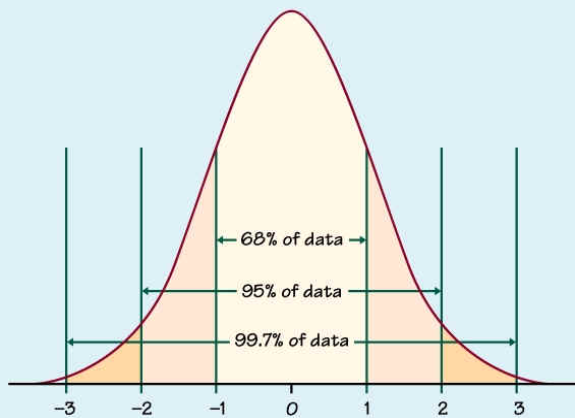

In [ ]:
from scipy import stats

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df_imputed_knn.iloc[:,:16].select_dtypes(include=numerics)

z = np.abs(stats.zscore(df_numeric))
threshold = 3
print('list of outliers:', '\n', np.where(z > threshold)[0], '\n', np.where(z > threshold)[1])
print('number of outliers:', np.where(z > threshold)[0].shape)

### Outliers according to 1.5 * IQR

In [ ]:
# Example: maxTemp
Q1_maxTemp = df_imputed_knn.MaxTemp.quantile(0.25)
Q3_maxTemp = df_imputed_knn.MaxTemp.quantile(0.75)
IQR_maxTemp = Q3_maxTemp - Q1_maxTemp
upper_maxTemp = Q3_maxTemp + 1.5 * IQR_maxTemp
lower_maxTemp = Q1_maxTemp - 1.5 * IQR_maxTemp
print(f"""
Q1_maxTemp = {Q1_maxTemp}
Q3_maxTemp = {Q3_maxTemp}
IQR_maxTemp = {IQR_maxTemp}
upper_maxTemp = {upper_maxTemp}
lower_maxTemp = {lower_maxTemp}
""")

In [ ]:
# Q1, Q3 and IQR values for each variable
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
pd.concat([Q1, Q3, IQR], axis=1, keys= ['Q1', 'Q3', 'IQR'])

In [ ]:
features=df_imputed_knn.columns[:16]

In [ ]:
# Number of outliers in each column ignoring zero values by 1.5*IQR
k=1.5
print(f"Number of Outliers for {k}*IQR\n")

total=0
for col in features:
    outliers=detect_outliers(df_imputed_knn[df_imputed_knn[col] != 0], col, k)[2]
    total+=outliers
    if outliers > 0:
        print("{} outliers in '{}'".format(outliers,col))
# print("\n{} OUTLIERS TOTALLY".format(total))

### Plotting outliers

In [ ]:
def col_plot(df,col_name):
    plt.figure(figsize=(15,6))
    
    plt.subplot(141) # 1 satir x 4 sutun dan olusan ax in 1. sutununda calis
    plt.hist(df[col_name], bins = 20)
    f=lambda x:(np.sqrt(x) if x>=0 else -np.sqrt(-x))
    
    # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
    plt.axvline(x=df[col_name].mean() + 3*df[col_name].std(),color='red')
    plt.axvline(x=df[col_name].mean() - 3*df[col_name].std(),color='red')
    plt.xlabel(col_name)
    plt.tight_layout
    plt.xlabel("Histogram ±3z")
    plt.ylabel(col_name)

    plt.subplot(142)
    plt.boxplot(df[col_name]) # IQR katsayisi, defaultu 1.5
    plt.xlabel("IQR=1.5")

    plt.subplot(143)
    plt.boxplot(df[col_name].apply(f), whis = 1.5)
    plt.xlabel("ROOT SQUARE - IQR=1.5")

    plt.subplot(144)
    plt.boxplot(np.log(df[col_name]+0.1), whis = 1.5)
    plt.xlabel("LOGARITMIC - IQR=1.5")
    plt.show()

In [ ]:
for i in df_imputed_knn.columns[:16]:
    col_plot(df_imputed_knn,i)

In [ ]:
z_scores=[]
for i in df_imputed_knn.columns[:16]:
    z_scores.append(outlier_inspect(df_imputed_knn,i)[2])

In [ ]:
# verinin 99% confidence interval daki z score lari.
print(z_scores)

### Dropping outliers

In [ ]:
# create columns for 3z scores, new column with z score
df_3z=df_imputed_knn.copy()

for x in df_imputed_knn.columns[:16]:
    df_3z[x + '_z'] = stats.zscore(df_3z[x])

for x in df_3z.columns[-len(df_imputed_knn.columns[:16]):]:
    df_3z = df_3z[(df_3z[x] < 3) & (df_3z[x] > -3)]
    
# drop _z columns
df_3z = df_3z.drop(columns=df_3z.columns[-len(df_imputed_knn.columns[:16]):])

print('Number of Outliers:',len(df_imputed_knn)-len(df_3z))

In [ ]:
# 3 z aralik disindaki datanin outlier kabul edildiginde olusturulan yeni dataframe
# boolen degere sahip feature lar degerlendirmeye alinmamistir.
df_3z.iloc[:,:16]

In [ ]:
# after dropping outliers
df_3z.iloc[:,:16].describe().T.round(2)

In [ ]:
# before dropping outliers
df_imputed_knn.iloc[:,:16].describe().T.round(2)

### Isolation Forest
Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [ ]:
df_imputed_knn.columns

while 'RainTomorrow' is the target label, others are the independent features

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

df_isolation_forest = df_imputed_knn.copy()

y_iso = df_isolation_forest['RainTomorrow']
X_iso = df_isolation_forest.drop(['RainTomorrow'], axis=1)

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.10, random_state=42)
clf.fit(X_iso)
y_pred = clf.predict(X_iso)

# the model will predict an inlier with a label of +1 and an outlier with a label of -1

outliers_values = X_iso[clf.predict(X_iso) == -1]
outliers_values

In [ ]:
f"{len(outliers_values)} rows are outliers"

### LocalOutlierFactor
Unsupervised Outlier Detection using Local Outlier Factor (LOF)

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

* Her örneğin anomali puanına LocalOutlierFactor denir. Belirli bir örneğin yoğunluğunun komşularına göre yerel sapmasını ölçer. Anormallik puanının, nesnenin çevreleyen komşuluğa göre ne kadar izole olduğuna bağlı olduğu için yereldir. 
* Daha kesin olarak, yerellik, uzaklığı yerel yoğunluğu tahmin etmek için kullanılan knn tarafindan verilir. Bir örneğin yerel yoğunluğunu komşularının yerel yoğunluklarıyla karşılaştırarak, komşularından önemli ölçüde daha düşük yoğunluğa sahip örnekler belirlenebilir. Bunlar aykırı değerler olarak kabul edilir.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

df_lof = df_imputed_knn.copy()

scaler = MinMaxScaler()

columns = df_lof.columns

#note that we transform the data with MinMaxScaler
df_lof_scaled = scaler.fit_transform(df_lof)
df_lof_scaled = pd.DataFrame(df_lof, columns=columns)

y = df_lof_scaled['RainTomorrow']
X = df_lof_scaled.drop(['RainTomorrow'], axis=1)

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).

y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_
np.sort(X_scores)[:100]

In [ ]:
# threshold = X_scores.mean()-3*X_scores.std()
threshold = np.sort(X_scores)[len(X_scores)//10]
threshold

In [ ]:
X[(X_scores > threshold)==False].shape

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(x=X_scores)
plt.xlim((-1.5,-0.9))
plt.axvline(x=threshold,color='red')
plt.xlabel("Outliers by Threshold in Histogram")
plt.show()

### Handling Ouliers

In [ ]:
# Dropping observations with outliers
df_numeric_no = df_numeric[~((df_numeric < (Q1 - 1.5 * IQR)) |(df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_numeric.shape)
print(df_numeric_no.shape)

In [ ]:
df_numeric_no

### Replacing outliers of a variable with its median

In [ ]:
features = df_imputed_knn.columns[:16]
features

In [ ]:
# visualize outliers before Replacing outliers of a variable with its median

df_numeric = df_imputed_knn.iloc[:,:16].select_dtypes(include=numerics)
plt.figure(figsize=(20,20))
for k,v in enumerate(features):
    plt.subplot(4,4,k+1)
    sns.boxplot(data=df_numeric, x=v)

In [ ]:
for i in features:
    Q1_feature = df_numeric[i].quantile(0.25)
    Q3_feature = df_numeric[i].quantile(0.75)
    IQR_feature = Q3_feature - Q1_feature

    df_numeric[i][((df_numeric[i] < (
        Q1_feature - 1.5 * IQR_feature)) |(df_numeric[i] > (Q3_feature + 1.5 * IQR_feature)))] = df_numeric[i].median()

In [ ]:
df_numeric

In [ ]:
# visualize outliers after Replacing outliers of a variable with its median
plt.figure(figsize=(20,20))
for k,v in enumerate(features):
    plt.subplot(4,4,k+1)
    sns.boxplot(data=df_numeric, x=v)

### Replacing outliers of a variable according to threshold of LocalOutlierFactor

In [ ]:
# the threshold observation
df_imputed_knn[(X_scores == threshold)]

In [ ]:
threshold_row = df_imputed_knn[(X_scores == threshold)]
outliers = df_imputed_knn[(X_scores < threshold)]
# We get rid of the indexes of outliers and transformed them into array
outliers.to_records(index = False)
# We define a variable for outlier array
outliers_array = outliers.to_records(index = False)

# We replace all the outliers with the threshold row
outliers_array[:] = threshold_row.to_records(index = False)

df_numeric_no3 = df_imputed_knn.copy()

# the outlier observations after replacement by the threshold observation
df_numeric_no3[(X_scores < threshold)] = pd.DataFrame(outliers_array, index = df_numeric_no3[(X_scores < threshold)].index)
df_numeric_no3[(X_scores < threshold)].head()